# Tree-informed optimal transport of single-cell and spatial transcriptomics
Here we generate fake data consisting of paired spatial and single-cell gene expression data. We use Cassiopeia to generate a phylogenetic tree of single-cells and place them in 2D space, and from that we generate single-cell and spot-based gene expression. We then apply various approaches to map the single-cell data to spots.

In [ ]:
import anndata
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import squidpy as sq

import importlib
import os

file_path = os.path.join(os.getcwd(), "expression_simulator.py")
spec = importlib.util.spec_from_file_location("expression_simulator", file_path)
expression_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(expression_simulator)

file_path = os.path.join(os.getcwd(), "visium_simulator.py")
spec = importlib.util.spec_from_file_location("visium_simulator", file_path)
visium_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(visium_simulator)

file_path = os.path.join(os.getcwd(), "mappers.py")
spec = importlib.util.spec_from_file_location("mappers", file_path)
mappers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mappers)

file_path = os.path.join(os.getcwd(), "utils.py")
spec = importlib.util.spec_from_file_location("utils", file_path)
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text ins

## Generate cell lineage tree and spatial locations

In [2]:
# define lineage tracing data parameters
number_of_cassettes = 39
size_of_cassette = 1

# Specify the mutation proportion
mutation_proportion = 0.5
get_mutation_rate= lambda depth: -np.log2(1-mutation_proportion)/depth

number_of_states = 100
state_generating_distribution = lambda: np.random.exponential(1e-5)

# Specify the dropout proportions. Note that the heritable missing data proportion will be
# total_dropout_proportion - stochastic_proportion
total_dropout_proportion = 0.0
stochastic_proportion = 0.0
heritable_proportion = total_dropout_proportion - stochastic_proportion

get_heritable_rate = lambda depth: -np.log2(1-heritable_proportion)/depth

In [3]:
tree_simulator = lambda num_extant: cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution = lambda scale: np.random.lognormal(mean = np.log(scale),sigma = .5),
    initial_birth_scale = 1,
    death_waiting_distribution = lambda: np.random.uniform(0,4),
    mutation_distribution = lambda: 1,
    fitness_distribution = lambda: np.random.normal(0, .25),
    fitness_base = 1,
    num_extant = num_extant)

lt_simulator = lambda depth: cas.simulator.Cas9LineageTracingDataSimulator(
    number_of_cassettes = number_of_cassettes,
    size_of_cassette = size_of_cassette,
    mutation_rate = get_mutation_rate(depth),
    number_of_states=number_of_states,
    state_generating_distribution=state_generating_distribution,
    heritable_silencing_rate=get_heritable_rate(depth),
    stochastic_silencing_rate=stochastic_proportion,
    collapse_sites_on_cassette=True)

shape = (1,1)
spatial_simulator = cas.sim.ClonalSpatialDataSimulator(shape=shape,)

In [4]:
np.random.seed(1234678)

simulated_tree = tree_simulator(4000).simulate_tree()
lt_simulator(simulated_tree.get_mean_depth_of_tree()).overlay_data(simulated_tree)
spatial_simulator.overlay_data(simulated_tree)
simulated_tree = cas.sim.UniformLeafSubsampler(ratio = .1).subsample_leaves(simulated_tree)

# relabel nodes
node_map = {l: f'cell{l}' for l in simulated_tree.leaves}
simulated_tree.relabel_nodes(node_map)
simulated_tree.character_matrix.index = [f'cell{l}' for l in simulated_tree.character_matrix.index]
simulated_tree.cell_meta.index = simulated_tree.cell_meta.index.map(node_map)

simulated_tree.collapse_unifurcations()

In [5]:
simulated_adata = anndata.AnnData(obs=pd.DataFrame(index=simulated_tree.leaves))
simulated_adata.obs['library_id'] = 'simulated_puck'

simulated_adata.obsm['spatial'] = simulated_tree.cell_meta[['spatial_0', 'spatial_1']].to_numpy()

/Users/pedroferreira/projects/tumorot/phylospatial_mapping/utils.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[tree.leaves, 'Selection'] = "False"
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm

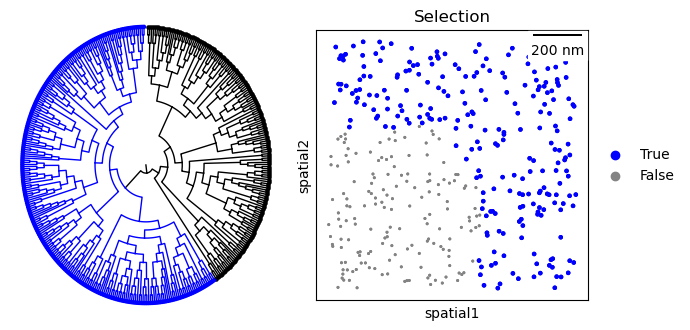

/Users/pedroferreira/projects/tumorot/phylospatial_mapping/utils.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[tree.leaves, 'Selection'] = "False"
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm

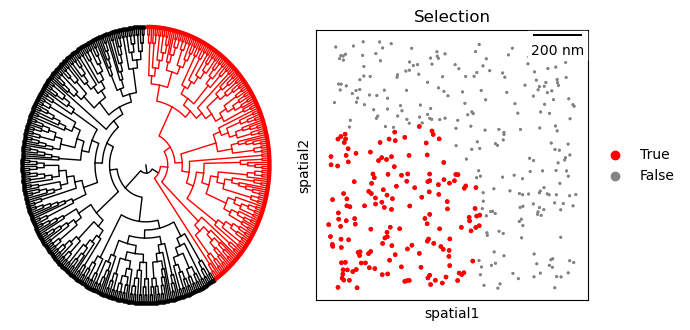

In [6]:
node = simulated_tree.root

# find three largest subclades
sizes = np.array([len(simulated_tree.leaves_in_subtree(child)) for child in simulated_tree.children(node)])
iid = np.argsort(-sizes)[:3]

colors = ['blue', 'red', '#E69F00', '#D34818']
clade_to_colors = {}
for _iter, child in zip(range(3), np.array(simulated_tree.children(node))[iid]):
    clade_to_colors[child] = colors[_iter]
    utils.plot_selection(simulated_tree, simulated_adata, child, colors[_iter])

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_37633/4062394524.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(simulated_adata.obsm['spatial'][:, 0], simulated_adata.obsm['spatial'][:, 1], cmap='viridis', s=10)


(np.float64(-0.04956570210197242),
 np.float64(1.0499020147617557),
 np.float64(-0.047410113364458085),
 np.float64(1.0520576034992701))

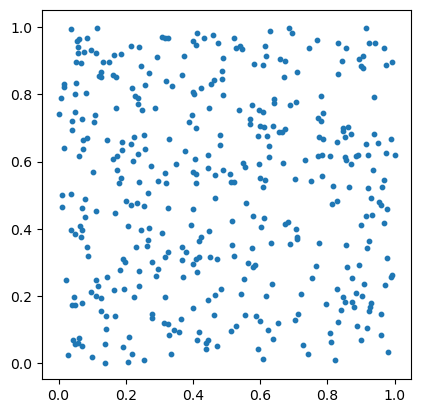

In [7]:
plt.scatter(simulated_adata.obsm['spatial'][:, 0], simulated_adata.obsm['spatial'][:, 1], cmap='viridis', s=10)
plt.axis('square')

## Simulate single-cell gene expression profiles
Using a trait model on the tree and tree-indepedent spatial effects  

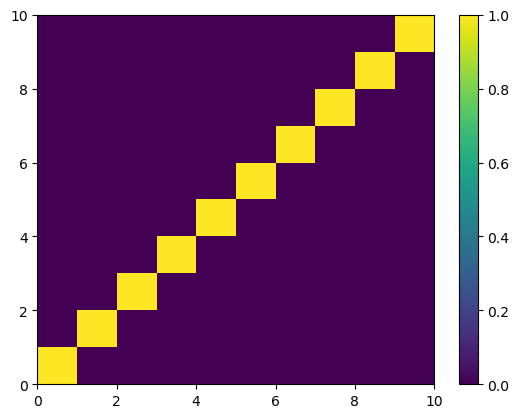

In [8]:
# Brownian Motion model on the tree
n_genes = 10
trait_covariances = np.zeros((n_genes, n_genes))
trait_covariances[np.arange(n_genes), np.arange(n_genes)] = 1.
trait_covariances = pd.DataFrame(trait_covariances, index=["G" + str(i) for i in range(n_genes)], columns=["G" + str(i) for i in range(n_genes)])
plt.pcolormesh(trait_covariances)
plt.colorbar()
plt.show()

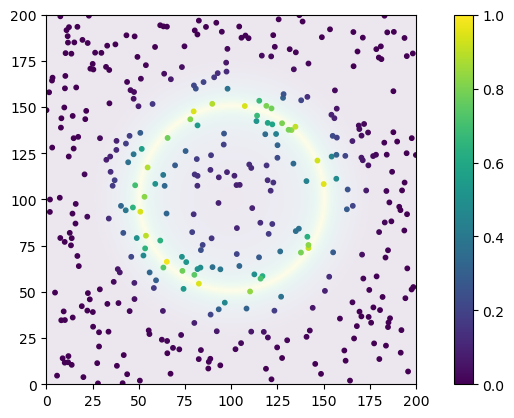

In [9]:
# A continuous spatial effect
spatial_activation = visium_simulator.prior(200, visium_simulator.circ_equation, decay_factor=.001, radius=50, center_x=100, center_y=100)
gene_program = np.zeros((n_genes,))
gene_program[np.random.choice(n_genes, size=5)] = 10. # activate these genes


x = simulated_adata.obsm['spatial'][:, 0]
y = simulated_adata.obsm['spatial'][:, 1]

# Map scatter points to heatmap indices
nx, ny = spatial_activation.shape
xi = (x / 1 * (nx - 1)).astype(int)
yi = (y / 1 * (ny - 1)).astype(int)
# Get heatmap values for each point
cvals = spatial_activation[yi, xi]
# Scatter colored by heatmap values
sc = plt.scatter(x * 200, y * 200, c=cvals, cmap="viridis", s=10, vmax=1, vmin=0)
plt.colorbar()
# Show the heatmap in the background too
plt.imshow(
    spatial_activation,
    extent=[0, 200, 0, 200],
    origin="lower",
    cmap="viridis",
    alpha=0.1
)
plt.axis('square')

plt.show()

In [10]:
# Generate single-cell expression profiles
file_path = os.path.join(os.getcwd(), "expression_simulator.py")
spec = importlib.util.spec_from_file_location("expression_simulator", file_path)
expression_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(expression_simulator)

ex_simulator = expression_simulator.ExpressionSimulator(trait_covariances, spatial_activation, gene_program)
ex_simulator.overlay_data(simulated_tree, alpha=0.0)
expression = simulated_tree.cell_meta[[f'G{i}' for i in range(ex_simulator.n_genes)]].to_numpy()

## Single-cell RNA-sequencing data simulation

In [11]:
# Simulate single-cell gene expression data
ss_cell_library_sizes = np.random.poisson(1000, size=ex_simulator.n_leaves) * 0 + 1
ss_gene_sizes = np.random.poisson(100, size=ex_simulator.n_genes) * 0 + 1
ss_transcriptomes = np.random.poisson(np.exp(expression) * ss_cell_library_sizes[:, None] * ss_gene_sizes[None, :])
ss_simulated_adata = anndata.AnnData(pd.DataFrame(ss_transcriptomes, index=ex_simulator.leaf_names, columns=ex_simulator.gene_names))
ss_simulated_adata.obs['library_id'] = 'simulated_puck'
ss_simulated_adata.obsm['spatial'] = simulated_tree.cell_meta[['spatial_0', 'spatial_1']].to_numpy()

In [12]:
gene_program

array([10.,  0., 10.,  0.,  0.,  0., 10., 10.,  0.,  0.])

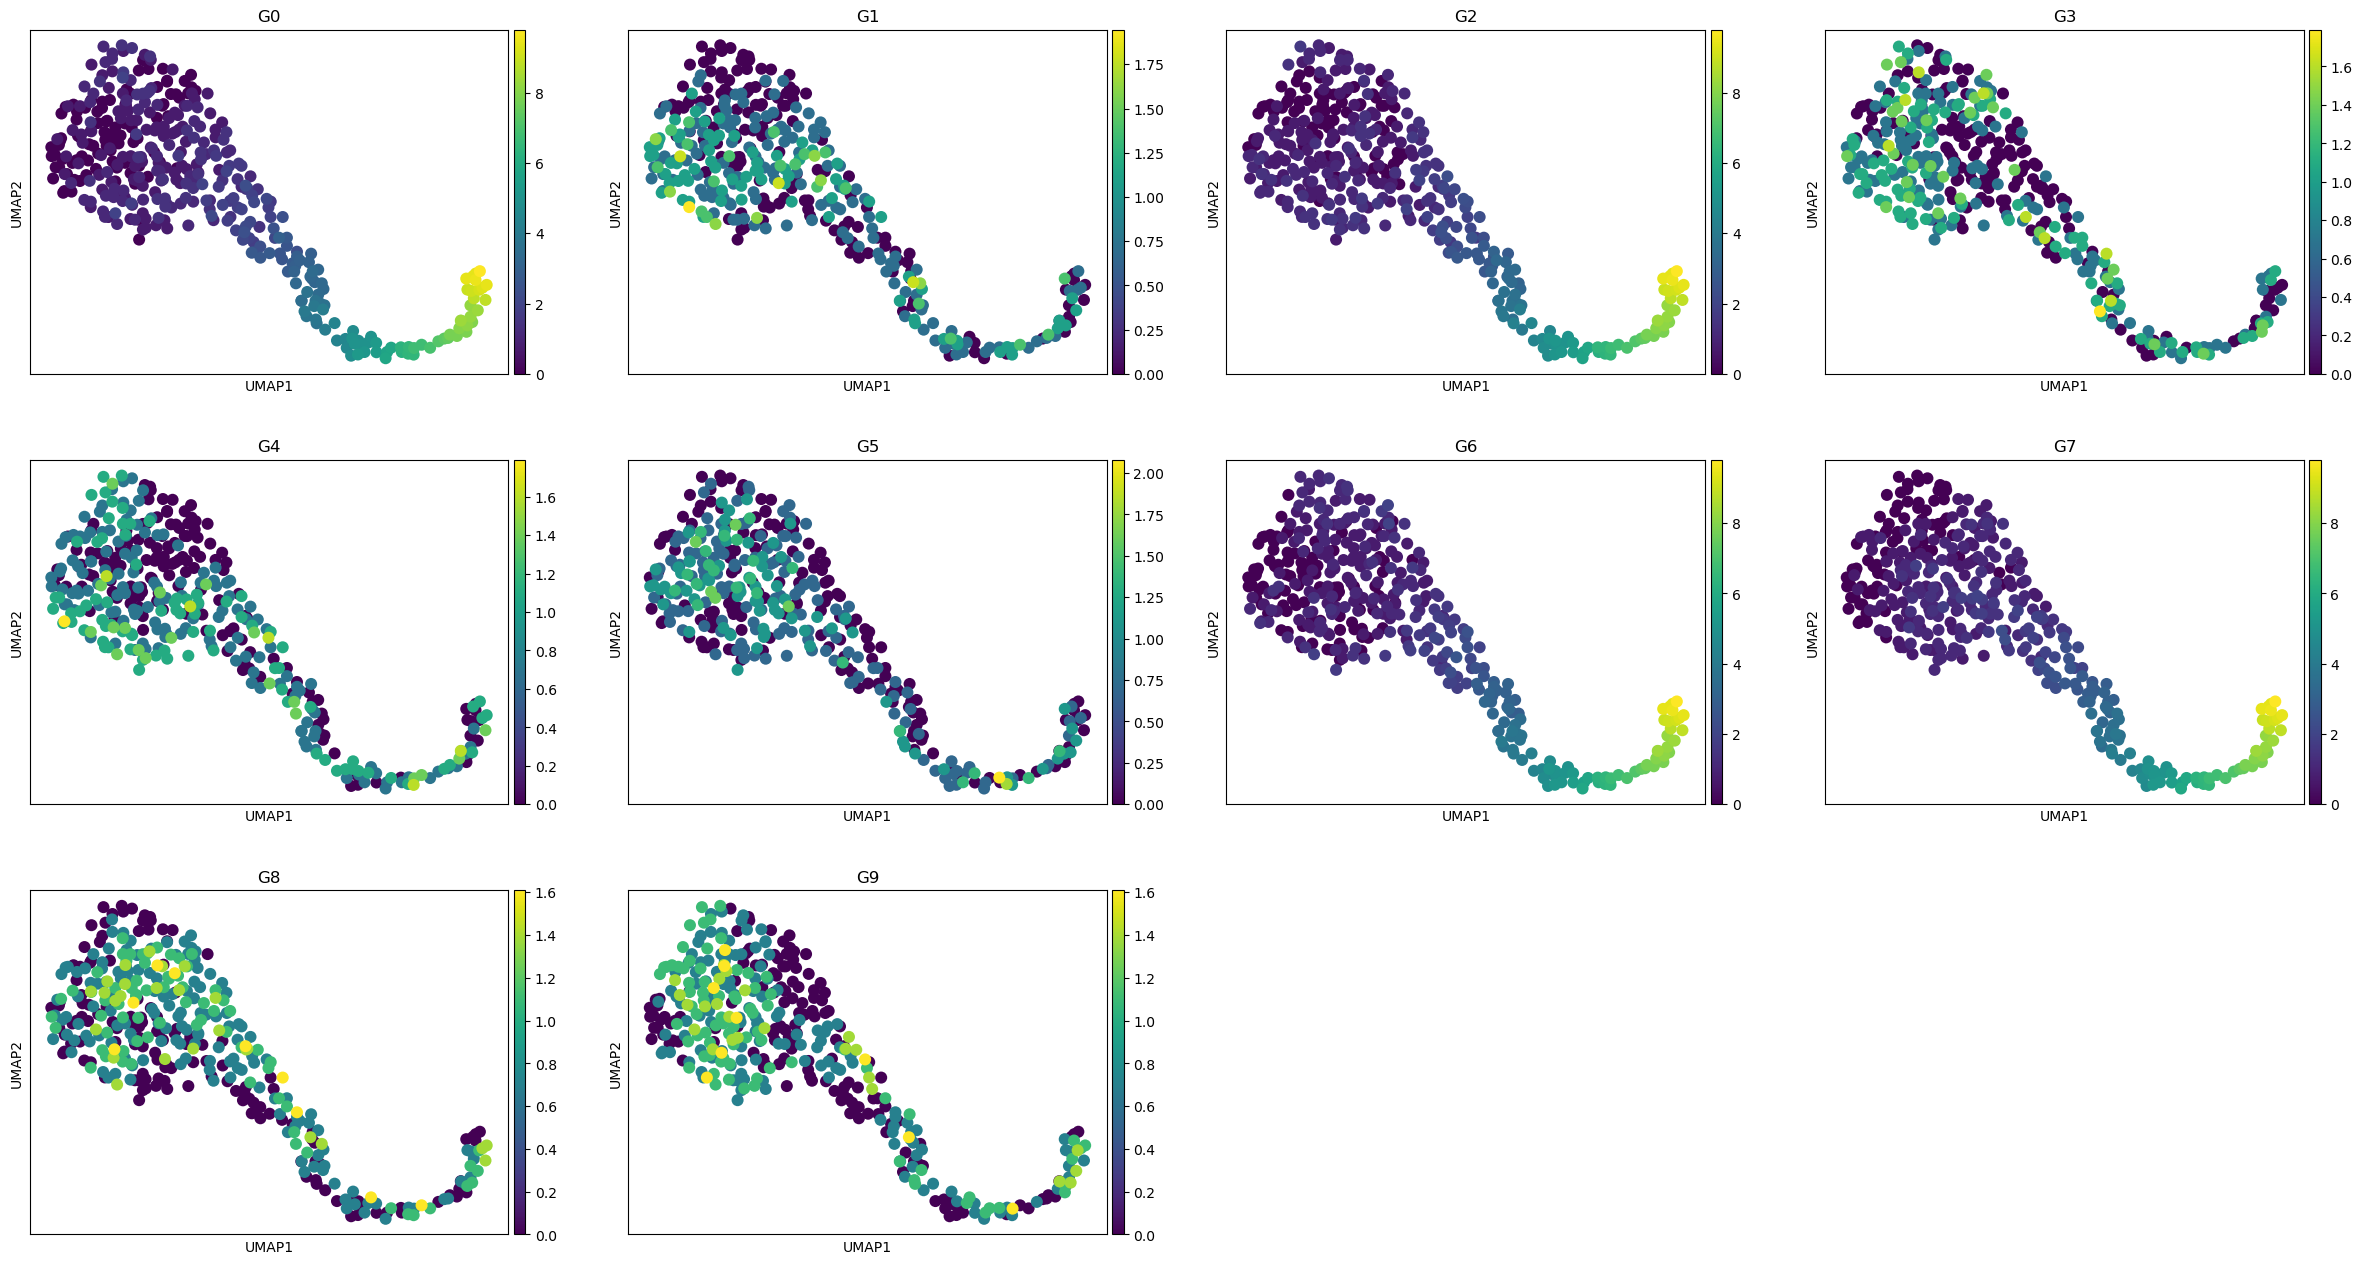

In [14]:
# Look at the UMAP colored by clade and by genes in the spatial program
import scanpy as sc

# sc.pp.normalize_total(ss_simulated_adata, inplace=True)
sc.pp.log1p(ss_simulated_adata)
sc.pp.pca(ss_simulated_adata)
sc.pp.neighbors(ss_simulated_adata)
sc.tl.umap(ss_simulated_adata)
sc.pl.umap(ss_simulated_adata, color=ex_simulator.gene_names, legend_loc='on data')
plt.show()

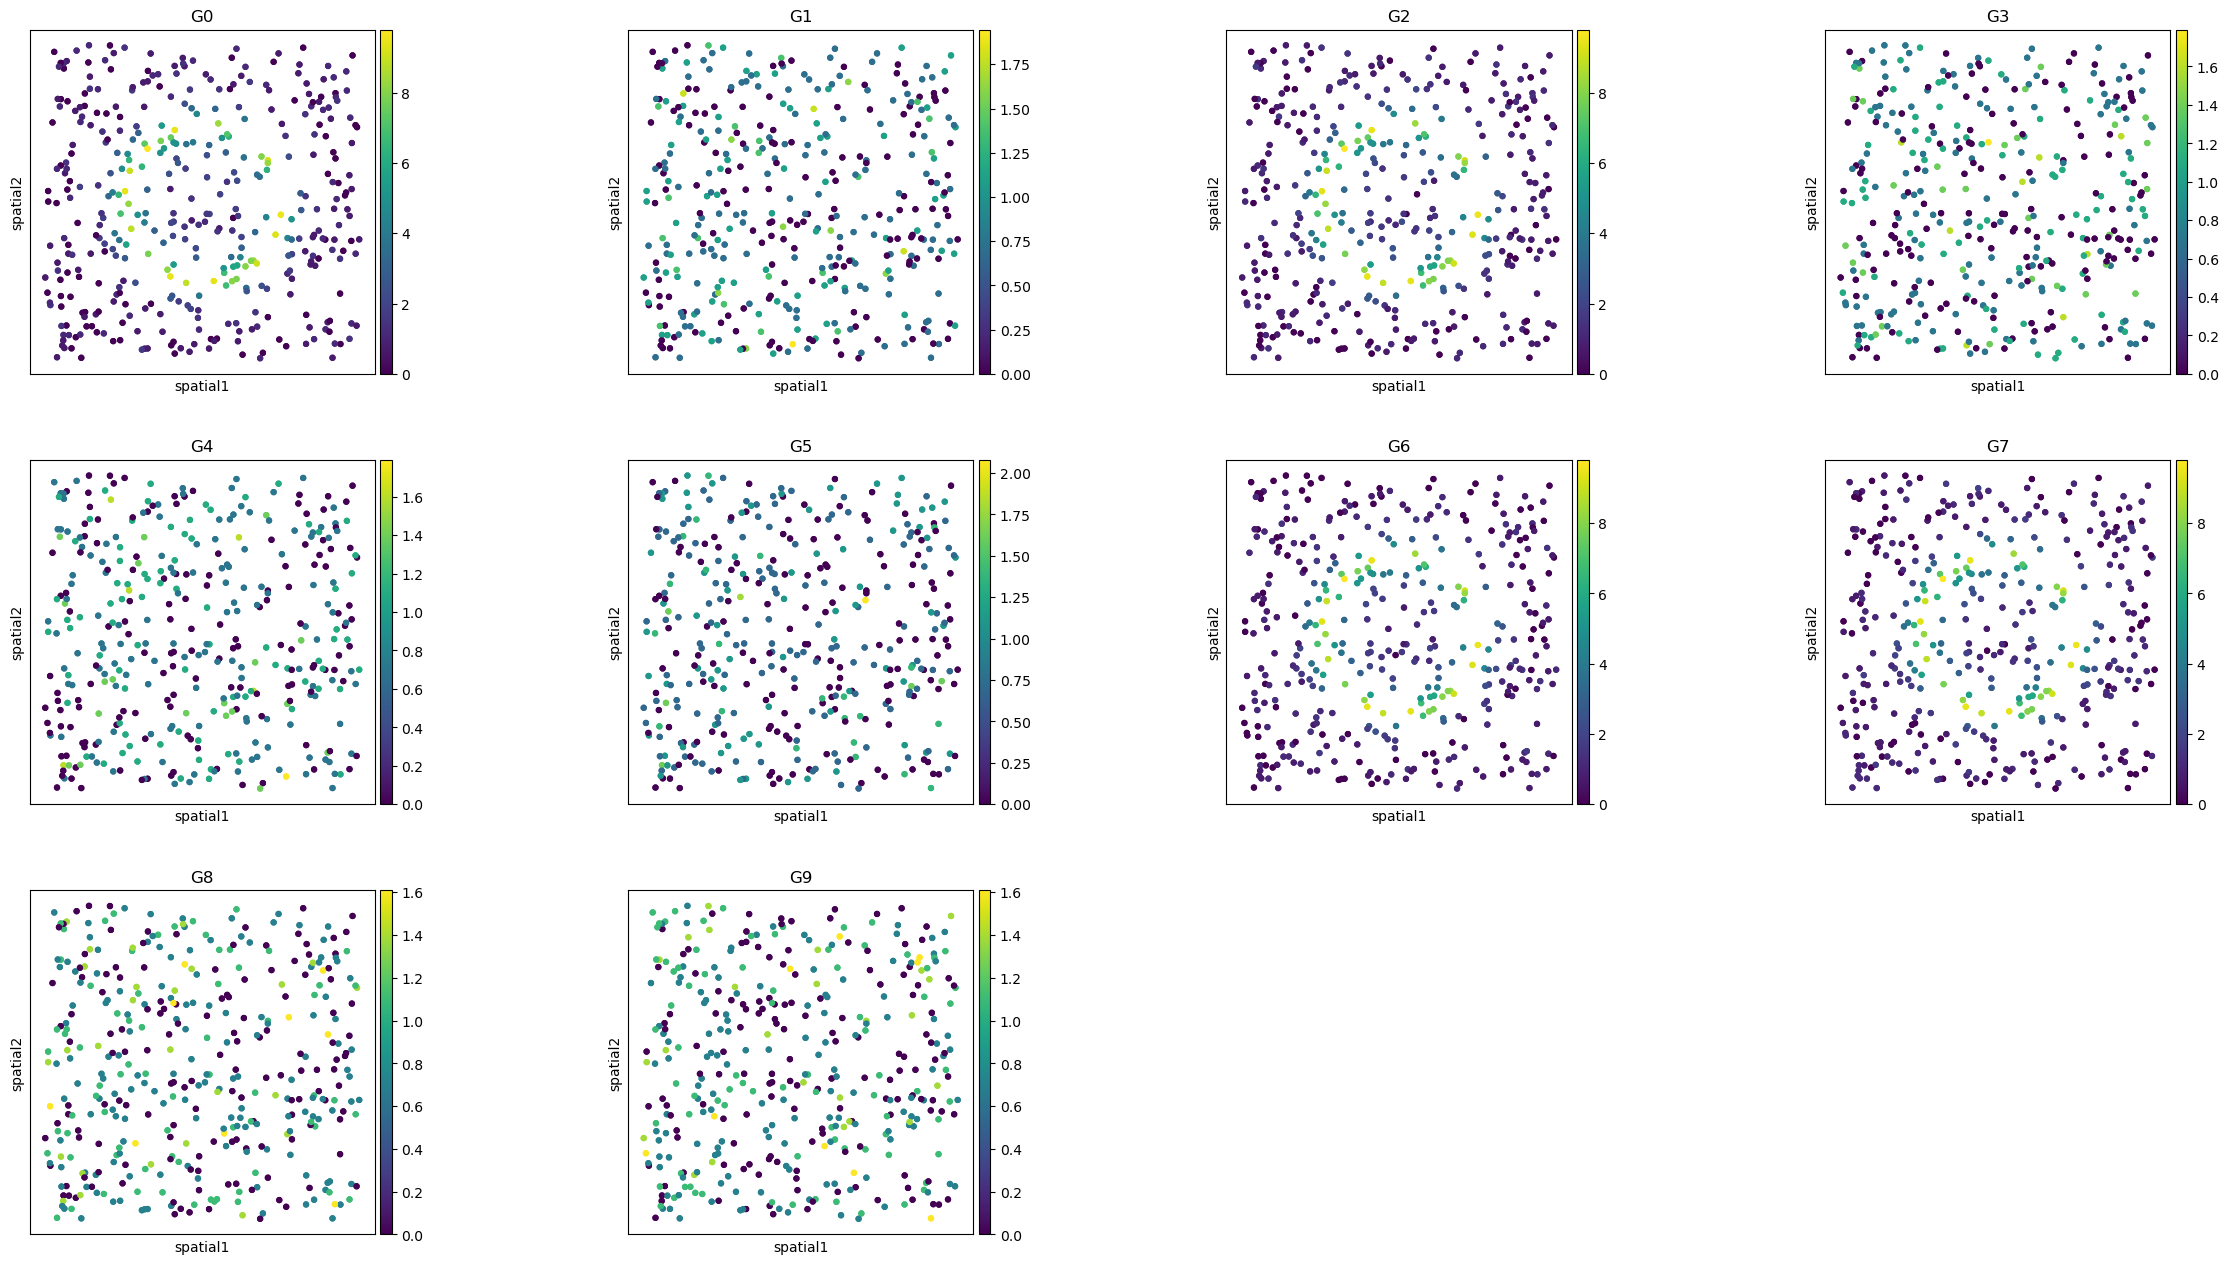

In [15]:
sq.pl.spatial_scatter(ss_simulated_adata, color=ex_simulator.gene_names, library_id='puck1',
                    size=50, shape=None)

## Spatial transcriptomics data simulation

In [16]:

gx, gy = visium_simulator.map_points_to_grid_lowerleft(
    x, y,
    xmin=0.0, ymin=0.0, 
    dx=.05, dy=0.05
)

In [17]:
cell_spot_locations = np.c_[gx, gy]
spots = np.unique(cell_spot_locations, axis=0)
# Make a vector of cell to spot names indicating which spot each cell belongs to
# For each cell, find the index of its spot in the unique spots array, then assign the corresponding spot name
cells_to_spots = np.array([
    f'spot_{np.where((spots == loc).all(axis=1))[0][0]}' for loc in cell_spot_locations
])


In [18]:
# Simulate spatial gene expression data
n_spots = spots.shape[0]
spot_expression = np.zeros((n_spots, n_genes))
spot_names = [f'spot_{i}' for i in range(n_spots)]
for spot in range(n_spots):
    spot_cells = np.where(cells_to_spots == f'spot_{spot}')[0]
    spot_expression[spot] = np.mean(expression[spot_cells], axis=0) # all transcripts
spatial_spot_library_sizes = np.random.poisson(1000, size=n_spots) * 0 + 1
spatial_spot_gene_sizes = np.random.poisson(100, size=n_genes) * 0 + 1
spatial_transcriptomes = np.random.poisson(np.exp(spot_expression) * spatial_spot_library_sizes[:, None] * spatial_spot_gene_sizes[None, :])
spatial_simulated_adata = anndata.AnnData(pd.DataFrame(spatial_transcriptomes, index=spot_names, columns=ex_simulator.gene_names))
spatial_simulated_adata.obsm['spatial'] = spots

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_37633/1044676663.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=ex_simulator.gene_names, spot_size=.05)


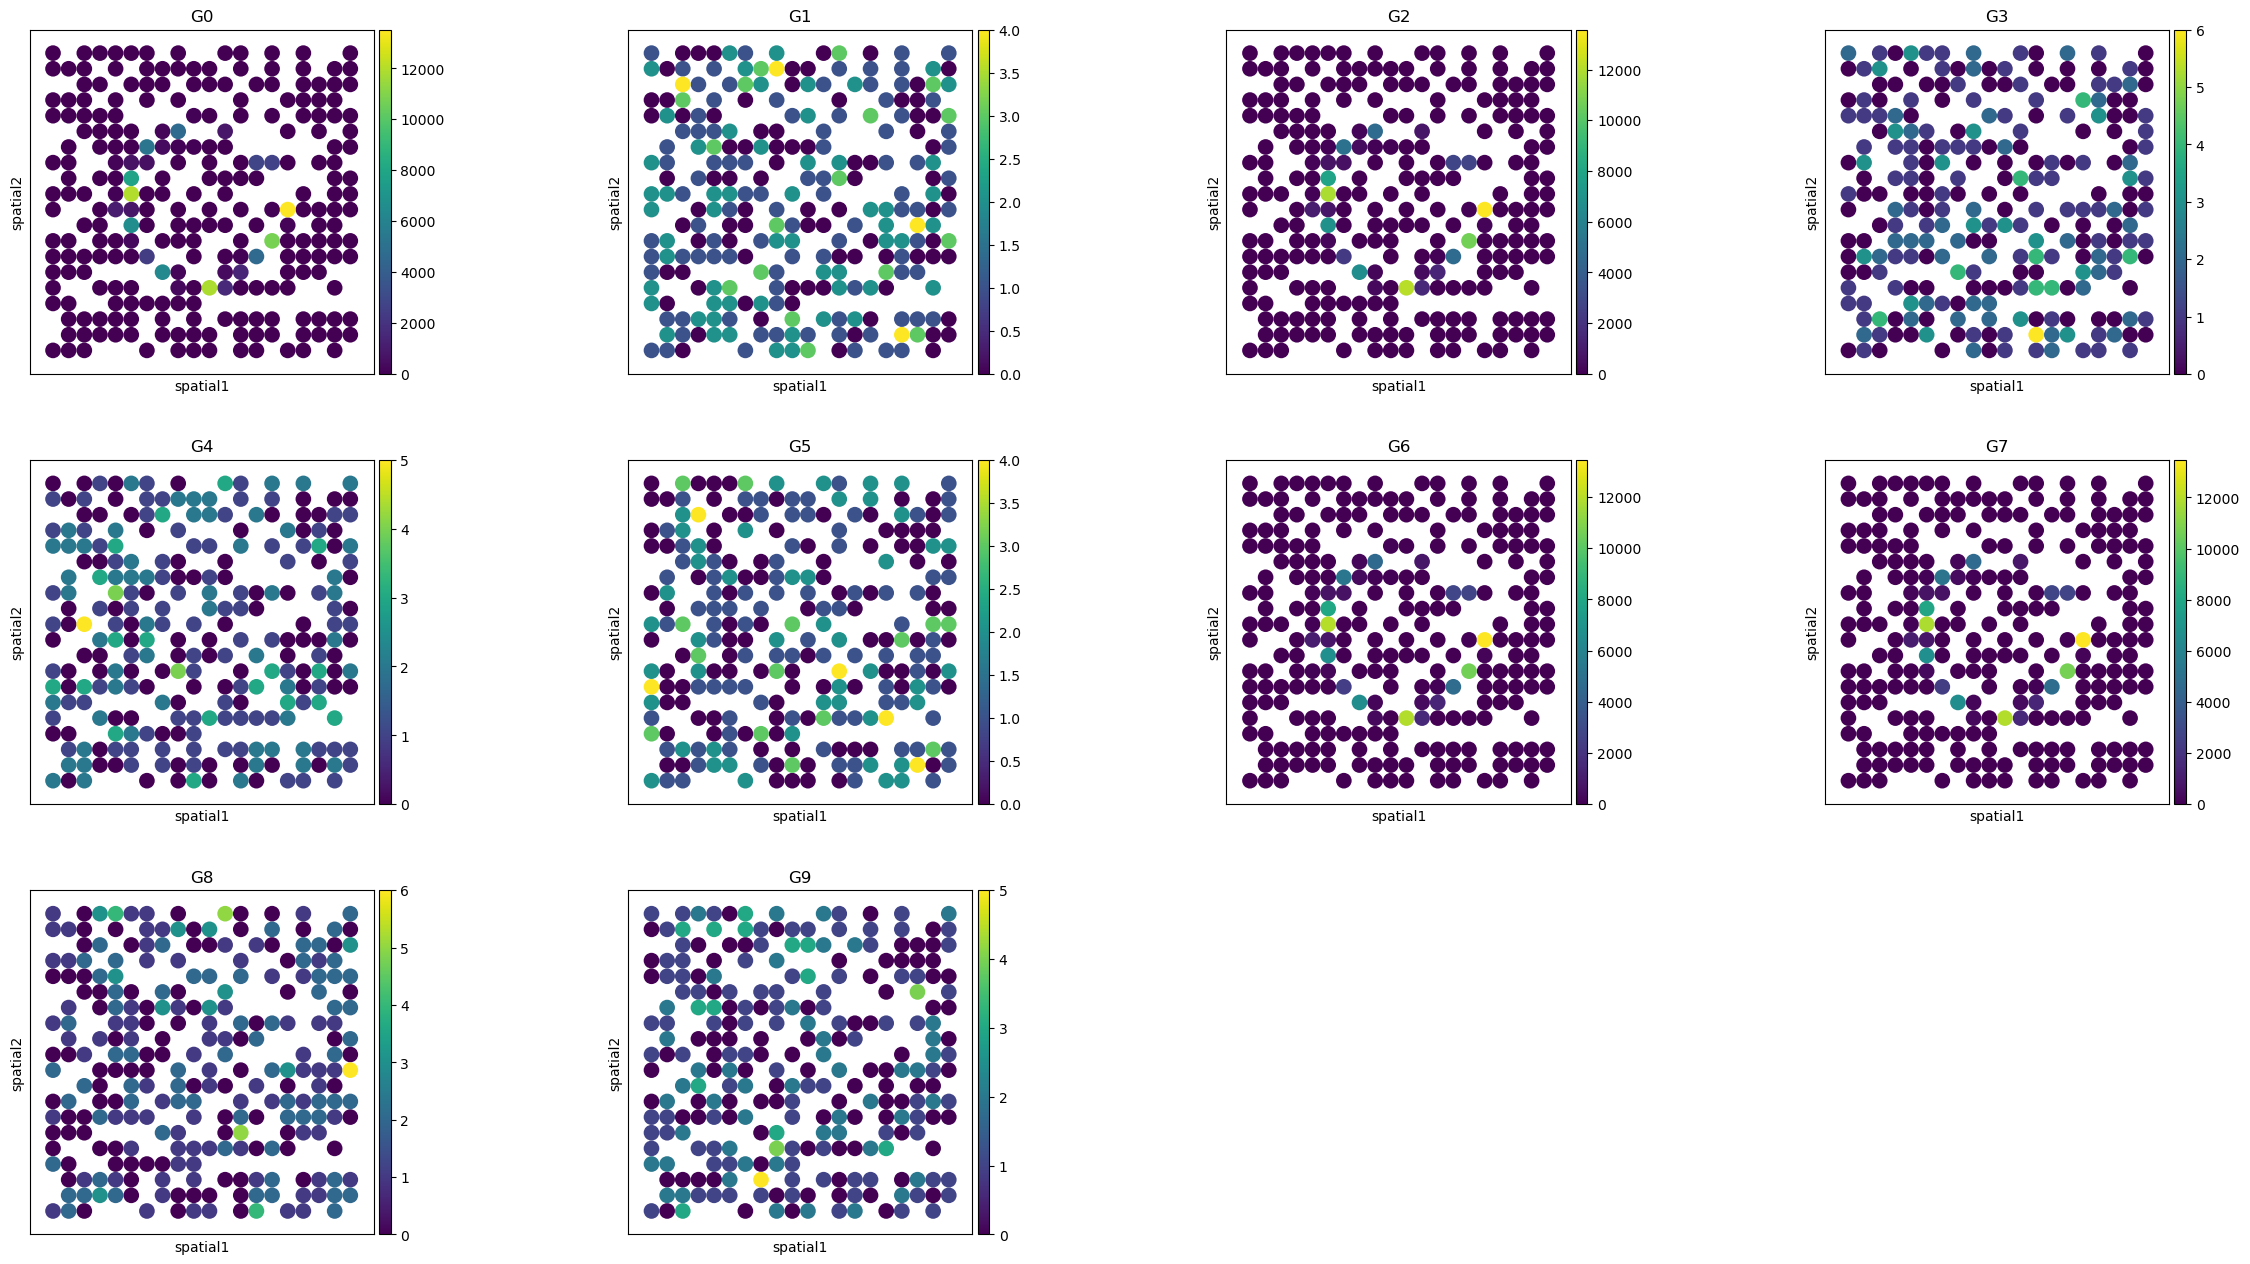

In [19]:
# Look at the spatial data
sc.pl.spatial(spatial_simulated_adata, color=ex_simulator.gene_names, spot_size=.05)

## Map the single-cell data to the spatial data

In [20]:
file_path = os.path.join(os.getcwd(), "mappers.py")
spec = importlib.util.spec_from_file_location("mappers", file_path)
mappers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mappers)

In [21]:
# Get distance matrices
tree_distance_matrix = cas.data.compute_phylogenetic_weight_matrix(simulated_tree)
spatial_distance_matrix = squareform(pdist(spots, metric='euclidean'))

### Correlation-based

In [22]:
# Assign each cell to the spot with the highest correlation
coupling = mappers.pairwise_correlations(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
correlation_assignments = np.argmax(coupling, axis=1)
correlation_assignments = spatial_simulated_adata.obs.index[correlation_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(correlation_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")


Assignment accuracy: 0.013


### Optimal transport on expression only

In [23]:
coupling = mappers.optimal_transport(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
gw_assignments = np.argmax(coupling, axis=1)
gw_assignments = spatial_simulated_adata.obs.index[gw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(gw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

Assignment accuracy: 0.003


/Users/pedroferreira/projects/tumorot/phylospatial_mapping/mappers.py:27: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  T_ot = ot.emd([], [], M)


### Gromov-Wasserstein OT on tree and space only

In [24]:
coupling = mappers.gw(np.asarray(tree_distance_matrix), np.asarray(spatial_distance_matrix))
gw_assignments = np.argmax(coupling, axis=1)
gw_assignments = spatial_simulated_adata.obs.index[gw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(gw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

Assignment accuracy: 0.013


### Fused Gromov-Wasserstein OT

In [25]:
coupling = mappers.fgw(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes), np.asarray(tree_distance_matrix), np.asarray(spatial_distance_matrix), alpha=.5)
fgw_assignments = np.argmax(coupling, axis=1)
fgw_assignments = spatial_simulated_adata.obs.index[fgw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(fgw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

Assignment accuracy: 0.003


/Users/pedroferreira/projects/tumorot/phylospatial_mapping/mappers.py:14: UserWarning: Input feature matrix consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input feature matrix consists of floating point elements.
  T_fgw = fused_gromov_wasserstein(M, C1, C2, w1, w2, loss_fun='square_loss', alpha=alpha)


### Joint FGW and alpha learning (ours) 
TODO